In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
import librosa
import librosa.display
from torch.utils.data import sampler
import torch.optim as optim
import json
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from torchinfo import summary

/home/prasad/anaconda3/envs/aec/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ICASSPDatasetHelper():
    #initialization 
    def __init__(self):
        self.sample_rate=8000
        fft_len=40
        hop_len=10
        self.dir= "./icassp_LUT_256x64.json"
        openfile=open(self.dir, "r")
        self.dataset_dict= json.load(openfile)
        indx=1
        self.keys={}
        for key  in self.dataset_dict.keys():
            self.keys[indx]=key
            indx+=1

        self.num_files_per_category=len(self.dataset_dict["echo_signal"].keys())

    #get the indexed file and sample rate
    def get_indxd_file(self,indx,src):
        category=self.keys[src]
        #load magnitude spectrum
        data=abs(np.load(self.dataset_dict[category][str(indx)]))
        Id= self.dataset_dict[category][str(indx)].split("/")[-1].split('.')[0]
        return (data,Id)

    #get the indexed file and sample rate
    def get_indxd_filestft(self,indx,src):
        category=self.keys[src]
        #load magnitude spectrum
        data=np.load(self.dataset_dict[category][str(indx)])
        Id= self.dataset_dict[category][str(indx)].split("/")[-1].split('.')[0]
        return (data,Id)

In [3]:
class ICASSP(Dataset):
    def __init__(self):
        #super().__init__(self)
        self.daps= ICASSPDatasetHelper()

    def __getitem__(self, index):
        mic,id=self.daps.get_indxd_file(index,2)
        fend,id=self.daps.get_indxd_file(index,3)
        nend,id=self.daps.get_indxd_file(index,4)
        return (mic,fend,nend)

    def __len__(self):
        
        #print (self.daps.num_files_per_category)
        return self.daps.num_files_per_category

In [4]:
dataset_train = ICASSP()
print(dataset_train.__len__())
print(dataset_train.daps.keys)

3240
{1: 'echo_signal', 2: 'nearend_mic_signal', 3: 'farend_speech', 4: 'nearend_speech'}


In [5]:
dtype = torch.float32 # we will be using float throughout this tutorial
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [6]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [7]:
NUM_TRAIN=2500
NUM_VAL=800
NUM_TEST=100
print_every = 100
dataset_train = ICASSP()
batch_size=4
loader_train = DataLoader(dataset_train, batch_size=batch_size, num_workers=8,
                          sampler=sampler.SequentialSampler(range(NUM_TRAIN)))
loader_val= DataLoader(dataset_train, batch_size=batch_size, num_workers=8,
                          sampler=sampler.SequentialSampler(range(NUM_TRAIN,NUM_VAL+NUM_TRAIN)))
loader_test = DataLoader(dataset_train, batch_size=batch_size, num_workers=8,
                          sampler=sampler.SequentialSampler(range(NUM_VAL+NUM_TRAIN, NUM_VAL+NUM_TRAIN+NUM_TEST)))

helper= ICASSPDatasetHelper()


In [8]:
print(dataset_train.daps.keys)

{1: 'echo_signal', 2: 'nearend_mic_signal', 3: 'farend_speech', 4: 'nearend_speech'}


In [9]:
#Create Model classes
# create a class for linear layers 
class DenseLayer(nn.Module):
    def __init__(self,input_size,output_size,dropOut_p):
        super().__init__()
        self.dense=nn.Linear(input_size,output_size,bias=True)
        self.activation=nn.Tanh()
        self.dropOut=nn.Dropout(p=dropOut_p,inplace=False)
    
    def forward(self,x):
        y=self.dense(x)
        y=self.activation(y)
        y=self.dropOut(y)
        return y

#class for convolutional layers
class ConvLayer(nn.Module):
    def __init__(self,in_ch,out_ch,kernel_size,stride,padding,dropOut_p):
        super().__init__()
        self.conv=nn.Conv2d(in_ch,out_ch,kernel_size, stride=stride,padding=padding)
        self.activation=nn.ReLU()
        self.dropOut=nn.Dropout2d(p=dropOut_p,inplace=False)
    
    def forward(self,x):
        y=self.conv(x)
        y=self.activation(y)
        y=self.dropOut(y)

        return y

#RNN model for Residual echo suppression
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, fclayer_dim, output_dim, num_layers,dropout_prob):
        super().__init__()
        # Defining the number of layers and the nodes in each layer
        self.layer_dim=num_layers
        self.hidden_dim=hidden_dim
        self.rnn = nn.LSTM(
            fclayer_dim, hidden_dim, num_layers, batch_first=True
        )
        self.tanh=nn.Tanh()
        self.fc1= nn.Linear(input_dim,fclayer_dim)
        self.fc2= nn.Linear(hidden_dim,output_dim)
        self.sig=nn.Sigmoid()


    def forward(self, x):
        
        y= self.fc1(x)

        y= self.tanh(y)
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, y.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(y)

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        #out = out[:, -1, :]
        out=self.tanh(out)
        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc2(out)
        out = self.sig(out)
        return out

In [10]:
#SNR loss where yhat is average power spectrum of de-nonlinearised/denoised signal/ clean signal power 
def Loss_MSE(yhat,y,lossfn):
    target = torch.ones(1).to(device=device)
    #yhat=yhat.squeeze(0)
    #y=y.squeeze(0)
    #loss=lossfn(yhat,y,target)
    loss=lossfn(yhat,y)
    return loss

In [11]:
def check_accuracy(loader, model,lossfn):
    print('Checking accuracy on validation set')
    model.eval()  # set model to evaluation mode
    mse=0
    with torch.no_grad():
        for mic, fend, nend in loader:

            x=torch.concat((mic,fend),1)
            #print(x.shape)          
            #iterate over each stft frame 
            x=x.to(device=device, dtype=dtype)
            mic=mic.to(device=device, dtype=dtype)
            nend=nend.to(device=device, dtype=dtype)
            x=torch.permute(x, (0, 2, 1))
            y=torch.permute(nend, (0, 2, 1))
            mic=torch.permute(mic, (0, 2, 1))
            pw_x=x*x
            # Forward pass: compute scores and loss
            mask = model(pw_x)

            yhat= mask*mic
            #yhat=yhat[:,:,:,-1]
            #y=y[:,:,:,-1]
            mse+= Loss_MSE(y,yhat,lossfn)
        mse = mse / len(loader)
        print("Validation loss is", mse.cpu().numpy())
        return  mse.cpu().numpy()

In [12]:
print_every=1
def train_model(model, optimizer, scheduler ,epochs=1):
    """
    Train a model on DAPS.
    
    Inputs:
    - model_fn: A Python function that performs the forward pass of the model.
      It should have the signature scores = model_fn(x, params) where x is a
      PyTorch Tensor of image data, params is a list of PyTorch Tensors giving
      model weights, and scores is a PyTorch Tensor of shape (N, C) giving
      scores for the elements in x.
    - params: List of PyTorch Tensors giving weights for the model
    - learning_rate: Python scalar giving the learning rate to use for SGD
    
    Returns: val loss and train loss
    """
    val_loss=[]
    train_loss=[]
    #lossfn=nn.CosineEmbeddingLoss(margin=0,reduction="mean")
    lossfn=nn.MSELoss()
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        running_loss = 0
        for t, (mic, fend,nend) in enumerate(loader_train):
            
           
            x=torch.concat((mic,fend),1)
            #print(x.shape)          
            #iterate over each stft frame 
            x=x.to(device=device, dtype=dtype)
            mic=mic.to(device=device, dtype=dtype)
            nend=nend.to(device=device, dtype=dtype)
            x=torch.permute(x, (0, 2, 1))
            y=torch.permute(nend, (0, 2, 1))
            mic=torch.permute(mic, (0, 2, 1))
            pw_x=x*x
            # Forward pass: compute scores and loss

            mask = model(pw_x)
            #print(mask.shape)
            yhat= mask*mic

            #yhat=yhat[:,:,:,-1]
            #y=y[:,:,:,-1]

            loss = Loss_MSE(yhat, y, lossfn)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            # Update parameters. We don't want to backpropagate through the
            running_loss += loss.item()
            

        if t % print_every == 0:
            print('Epoch %d, Iteration %d, loss = %.8f' % (e, t, (running_loss/len(loader_train))))
            train_loss.append(running_loss/len(loader_train))
            #check_accuracy_part2(loader_val, model_fn, params)
            
        vloss=check_accuracy(loader_val,model,lossfn)
        model.train()
        val_loss.append(vloss)
        scheduler.step(loss)
    return (train_loss,val_loss)

In [13]:
learning_rate = 1e-3
nfft_len=511
hop_size=nfft_len//4
specdims=(256,64)
model = LSTMNet(input_dim=specdims[0]*2, hidden_dim=25, fclayer_dim=25, output_dim=specdims[0], num_layers=1,dropout_prob=0.0)
# you can use Nesterov momentum in optim.SGD
#optimizer = optim.SGD(model.parameters(), lr=learning_rate,
#                     momentum=0.9, nesterov=True)
# you can use Nesterov momentum in optim.SGD
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [14]:
batch_size = batch_size
summary(model, input_size=(batch_size,specdims[1], specdims[0]*2))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

In [20]:
(train_loss,val_loss)=train_model(model, optimizer, scheduler,200)

Epoch 0, Iteration 624, loss = 1.08552617
Checking accuracy on validation set
Validation loss is 0.9113052
Epoch 1, Iteration 624, loss = 0.93259795
Checking accuracy on validation set
Validation loss is 0.8273717
Epoch 2, Iteration 624, loss = 0.87453206
Checking accuracy on validation set
Validation loss is 0.7883688
Epoch 3, Iteration 624, loss = 0.84614643
Checking accuracy on validation set
Validation loss is 0.76285523
Epoch 4, Iteration 624, loss = 0.82336798
Checking accuracy on validation set
Validation loss is 0.7434538
Epoch 5, Iteration 624, loss = 0.79753198
Checking accuracy on validation set
Validation loss is 0.72976035
Epoch 6, Iteration 624, loss = 0.78837136
Checking accuracy on validation set
Validation loss is 0.72061855
Epoch 7, Iteration 624, loss = 0.77152375
Checking accuracy on validation set
Validation loss is 0.7107819
Epoch 8, Iteration 624, loss = 0.76206484
Checking accuracy on validation set
Validation loss is 0.7007352
Epoch 9, Iteration 624, loss = 0.7

KeyboardInterrupt: 

In [21]:
model_path= "./misc/aec_lstm_160_may23.pth"
torch.save(model.state_dict(),model_path)

In [15]:
model_path= "./misc/aec_lstm_160_may23.pth"
model=LSTMNet(input_dim=specdims[0]*2, hidden_dim=25, fclayer_dim=25, output_dim=specdims[0], num_layers=1,dropout_prob=0.0)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [16]:
dataset=ICASSPDatasetHelper()
#test_index=19485
#test_index=1970
test_index=1290
model.to(device="cpu")
mic,_= dataset.get_indxd_file(test_index,2)
fend,_= dataset.get_indxd_file(test_index,3)
nend,_= dataset.get_indxd_file(test_index,4)
echo,_= dataset.get_indxd_file(test_index,1)
mic = torch.tensor(mic)
fend = torch.tensor(fend)
nend = torch.tensor(nend)
y=torch.permute(mic,(1,0))
x=torch.concat((mic,fend),0)
x= torch.permute(x,(1,0))
x=x.unsqueeze(0)
x=x.to(dtype=torch.float32)
model.eval()
with torch.no_grad():
    out=model(x*x)
out = out *y
out=out.squeeze(0)
out= torch.permute(out,(1,0))

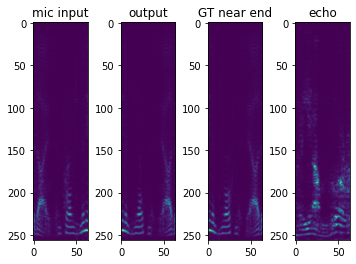

In [17]:
plt.figure()
plt.title("Comparison of echo cancellation output vs Ground Truth")
ax1=plt.subplot(1,4,1)
ax1.imshow(np.flip(mic.numpy(),0))
ax1.title.set_text("mic input")
ax2=plt.subplot(1,4,2)
ax2.imshow(np.flip(out.cpu().numpy()))
ax2.title.set_text("output")
ax3=plt.subplot(1,4,3)
ax3.imshow(np.flip(nend.numpy()))
ax3.title.set_text("GT near end")
ax4=plt.subplot(1,4,4)
ax4.imshow(np.flip(echo))
ax4.title.set_text("echo")

In [18]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(["train loss","validation loss"])

NameError: name 'train_loss' is not defined

Run a test file using the model to process and remove the echo

In [19]:
file_indx=42
mic_sig,_=librosa.load("../dataset/AEC-Challenge/datasets/synthetic/nearend_mic_signal/nearend_mic_fileid_"+str(file_indx)+".wav",sr=8000)
fend_sig,_=librosa.load("../dataset/AEC-Challenge/datasets/synthetic/farend_speech/farend_speech_fileid_"+str(file_indx)+".wav",sr=8000)
nend_sig,_=librosa.load("../dataset/AEC-Challenge/datasets/synthetic/nearend_speech/nearend_speech_fileid_"+str(file_indx)+".wav",sr=8000)
echo_sig,_=librosa.load("../dataset/AEC-Challenge/datasets/synthetic/echo_signal/echo_fileid_"+str(file_indx)+".wav",sr=8000)


In [20]:
nfft_len=511
mic_stft=librosa.stft(mic_sig,n_fft=nfft_len, hop_length=nfft_len//4,center=True)
fend_stft=librosa.stft(fend_sig,n_fft=nfft_len, hop_length=nfft_len//4,center=True)
nend_stft=librosa.stft(nend_sig,n_fft=nfft_len, hop_length=nfft_len//4,center=True)

In [21]:

fx=librosa.stft(fend_sig,n_fft=511,hop_length=511//4)
res_spec=np.zeros_like(fx)
for i in range(0,8):
    mic=  mic_stft[:,specdims[1]*i:specdims[1]*i+specdims[1]]
    fend= fend_stft[:,specdims[1]*i:specdims[1]*i+specdims[1]]
    nend= nend_stft[:,specdims[1]*i:specdims[1]*i+specdims[1]]
    tmic = torch.tensor(abs(mic))
    tfend = torch.tensor(abs(fend))
    tnend = torch.tensor(abs(nend))
    y=torch.permute(tmic,(1,0))
    x=torch.concat((tmic,tfend),0)
    x= torch.permute(x,(1,0))
    x=x.unsqueeze(0)
    x=x.to(dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        out=model(x*x)
    out = out*y
    out=out.squeeze(0)
    out= torch.permute(out,(1,0))
    out=out.cpu().numpy()
    mag,ph=librosa.magphase(mic)
    out=out*ph
    #print(out.shape)
    res_spec[:,specdims[1]*i:specdims[1]*i+specdims[1]]=out
    #specs[:,specdims[1]*i:specdims[1]*i+specdims[1]]=out*spec
res_nend=librosa.istft(res_spec,hop_length=nfft_len//4,n_fft=nfft_len)
#res_nend=librosa.util.normalize(res_nend)
print(res_nend.shape)

(79884,)


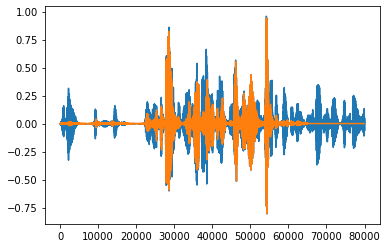

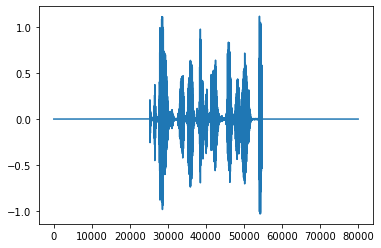

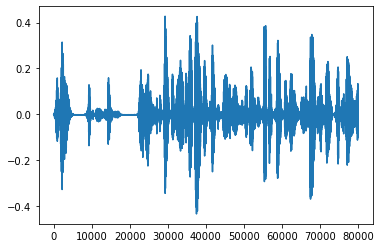

In [22]:
plt.figure()
plt.plot(mic_sig)
plt.plot(res_nend)
plt.figure()
plt.plot(nend_sig)
plt.figure()
plt.plot(echo_sig)


Dump processed files

In [105]:
wav.write("../op/echo_cancelled_fileid_"+str(file_indx)+".wav", 8000, res_nend)
wav.write("../op/mic_fileid_"+str(file_indx)+".wav", 8000, mic_sig)
wav.write("../op/nend_fileid_"+str(file_indx)+".wav", 8000, nend_sig)
wav.write("../op/fend_fileid_"+str(file_indx)+".wav", 8000, fend_sig)

In [106]:
class NLMS():
    #initialize
    def __init__(self,mu,taps):
        self.mu=mu
        self.N=taps
        self.e=0
        self.w=np.zeros((taps,1))
        self.xd=np.zeros((taps,1))

    #updates the filter sample by sample and updates weights sample by sample
    def run(self,x,d):
        N=self.N
        #udpate delay line 
        self.xd[0]=x
        #compute filter output
        y = np.dot(self.w.T,self.xd)
        #compute input energy
        pw=np.linalg.norm(self.xd)
        pw=pw*pw
        #pw=pw*pw
        #calculate error
        e = d - y
        self.e=e

        #normalize by input energy
        e= e/(pw+0.0000000001)
        #compute gradients
        Fw=self.mu*np.multiply(self.xd,e)
        
        Fw=Fw.reshape(Fw.shape[0],-1)
        #weight update
        self.w = self.w + Fw
    
        #filtered output post update
        y = np.dot(self.w.T,self.xd)
        #shift delay line
        self.xd[1:]=self.xd[:-1]
 
        #return current output sample, current error sample and current weights
        return (y,self.e,self.w)

In [107]:
#test wrapper for NLMS filter on aec data for single talk case
taps=1024
lmscls= NLMS(0.0001,taps)
w1=np.zeros((taps,1))
y1=np.zeros_like(fend_sig)
e1=np.zeros_like(fend_sig)
for i in range(0,len(res_nend)):
    (y1[i],e1[i],w3)=lmscls.run(fend_sig[i],res_nend[i])

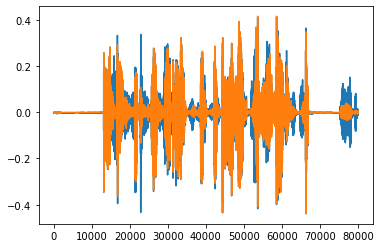

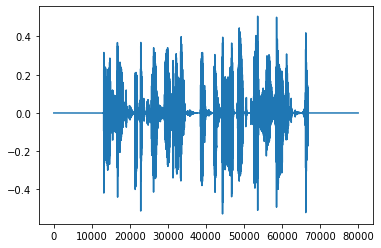

In [108]:
plt.figure()
plt.plot(mic_sig)
plt.plot(e1)
plt.figure()
plt.plot(nend_sig)


In [66]:
wav.write("../op/lmsnecho_cancelled_fileid_"+str(file_indx)+".wav", 8000, e1)
wav.write("../op/mic_fileid_"+str(file_indx)+".wav", 8000, mic_sig)
wav.write("../op/nend_fileid_"+str(file_indx)+".wav", 8000, nend_sig)
wav.write("../op/fend_fileid_"+str(file_indx)+".wav", 8000, fend_sig)